# IMPORTATION DES DONNEES ET RENOMMAGE DES COLONNES

# I ) Importation

In [3]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn

1. Montage du disque Google Drive 

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Importation des tables

In [5]:
data2019=pd.read_csv('/content/drive/MyDrive/FAOSTAT_data_3-12-2019.csv')
population2019=pd.read_csv('/content/drive/MyDrive/population2019.csv')
population2017=pd.read_csv('/content/drive/MyDrive/population2017.csv')
produits_animaux2019=pd.read_csv('/content/drive/MyDrive/animaux2019.csv')
data2019.drop(data2019[data2019['Produit']=='Population'].index, inplace=True)  #le mot population s'est glissé dans la liste des produits

Fonction qui permet de créer notre table avec les colonnes dont on besoin pour l'étude.

In [6]:
#Création de la fonction
def create_tab(data):
  tmp=data[['Zone','Produit']]
  for col in set(data['Élément']) :
    p=data[data['Élément']==col][['Zone','Produit','Valeur']]
    p.rename(columns={'Valeur':col}, inplace=True)
    tmp=pd.merge(tmp,p, how='left',on=['Zone','Produit'])
  tmp.drop_duplicates(inplace=True)
  return tmp

#Création de la table data2019 contenant les colonnes 
data2019=create_tab(data2019)

#Séléction des variables pertinentes
data2019=data2019[['Zone','Produit','Disponibilité de protéines en quantité (g/personne/jour)','Disponibilité alimentaire (Kcal/personne/jour)']]

On rajoute la colonne (variable) popuplation 2019 et 2017 dans la table *data2019*. puis on renomme les variables de la table.

In [7]:
data2019=pd.merge(data2019, population2019[['Zone','Valeur']], how='left', on=['Zone'])
data2019=pd.merge(data2019, population2017[['Zone','Valeur']], how='left', on=['Zone'])
data2019.rename(columns={'Valeur_x':'pop_2019', 'Valeur_y':'pop_2017',
                         'Disponibilité de protéines en quantité (g/personne/jour)':'dispo_prot',
                         'Disponibilité alimentaire (Kcal/personne/jour)':'dispo_cal'}, inplace=True)

## Quelques fonctions pour tracer

In [8]:
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import numpy as np
import pandas as pd
from scipy.cluster.hierarchy import dendrogram

def display_circles(pcs, n_comp, pca, axis_ranks, labels=None, label_rotation=0, lims=None):
    for d1, d2 in axis_ranks: # On affiche les 3 premiers plans factoriels, donc les 6 premières composantes
        if d2 < n_comp:

            # initialisation de la figure
            fig, ax = plt.subplots(figsize=(7,6))

            # détermination des limites du graphique
            if lims is not None :
                xmin, xmax, ymin, ymax = lims
            elif pcs.shape[1] < 30 :
                xmin, xmax, ymin, ymax = -1, 1, -1, 1
            else :
                xmin, xmax, ymin, ymax = min(pcs[d1,:]), max(pcs[d1,:]), min(pcs[d2,:]), max(pcs[d2,:])

            # affichage des flèches
            # s'il y a plus de 30 flèches, on n'affiche pas le triangle à leur extrémité
            if pcs.shape[1] < 30 :
                plt.quiver(np.zeros(pcs.shape[1]), np.zeros(pcs.shape[1]),
                   pcs[d1,:], pcs[d2,:], 
                   angles='xy', scale_units='xy', scale=1, color="grey")
                # (voir la doc : https://matplotlib.org/api/_as_gen/matplotlib.pyplot.quiver.html)
            else:
                lines = [[[0,0],[x,y]] for x,y in pcs[[d1,d2]].T]
                ax.add_collection(LineCollection(lines, axes=ax, alpha=.1, color='black'))
            
            # affichage des noms des variables  
            if labels is not None:  
                for i,(x, y) in enumerate(pcs[[d1,d2]].T):
                    if x >= xmin and x <= xmax and y >= ymin and y <= ymax :
                        plt.text(x, y, labels[i], fontsize='14', ha='center', va='center', rotation=label_rotation, color="blue", alpha=0.5)
            
            # affichage du cercle
            circle = plt.Circle((0,0), 1, facecolor='none', edgecolor='b')
            plt.gca().add_artist(circle)

            # définition des limites du graphique
            plt.xlim(xmin, xmax)
            plt.ylim(ymin, ymax)
        
            # affichage des lignes horizontales et verticales
            plt.plot([-1, 1], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-1, 1], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Cercle des corrélations (F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)
        
def display_factorial_planes(X_projected, n_comp, pca, axis_ranks, labels=None, alpha=1, illustrative_var=None):
    for d1,d2 in axis_ranks:
        if d2 < n_comp:
 
            # initialisation de la figure       
            fig = plt.figure(figsize=(7,6))
        
            # affichage des points
            if illustrative_var is None:
                plt.scatter(X_projected[:, d1], X_projected[:, d2], alpha=alpha)
            else:
                illustrative_var = np.array(illustrative_var)
                for value in np.unique(illustrative_var):
                    selected = np.where(illustrative_var == value)
                    plt.scatter(X_projected[selected, d1], X_projected[selected, d2], alpha=alpha, label=value)
                plt.legend()

            # affichage des labels des points
            if labels is not None:
                for i,(x,y) in enumerate(X_projected[:,[d1,d2]]):
                    plt.text(x, y, labels[i],
                              fontsize='14', ha='center',va='center') 
                
            # détermination des limites du graphique
            boundary = np.max(np.abs(X_projected[:, [d1,d2]])) * 1.1
            plt.xlim([-boundary,boundary])
            plt.ylim([-boundary,boundary])
        
            # affichage des lignes horizontales et verticales
            plt.plot([-100, 100], [0, 0], color='grey', ls='--')
            plt.plot([0, 0], [-100, 100], color='grey', ls='--')

            # nom des axes, avec le pourcentage d'inertie expliqué
            plt.xlabel('F{} ({}%)'.format(d1+1, round(100*pca.explained_variance_ratio_[d1],1)))
            plt.ylabel('F{} ({}%)'.format(d2+1, round(100*pca.explained_variance_ratio_[d2],1)))

            plt.title("Projection des individus (sur F{} et F{})".format(d1+1, d2+1))
            plt.show(block=False)

def display_scree_plot(pca):
    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree)
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o')
    plt.xlabel("rang de l'axe d'inertie")
    plt.ylabel("pourcentage d'inertie")
    plt.title("Eboulis des valeurs propres")
    plt.show(block=False)

def plot_dendrogram(Z, names):
    plt.figure(figsize=(10,25))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    dendrogram(
        Z,
        labels = names,
        orientation = "left",
    )
    plt.show()


# II) Création de notre jeu de données

In [9]:
data2019

,Zone,Produit,dispo_prot,dispo_cal,pop_2019,pop_2017
0,Afghanistan,Blé et produits,37.41,1387.0,38042.0,36296.0
1,Afghanistan,Riz et produits,2.39,126.0,38042.0,36296.0
2,Afghanistan,Orge et produits,0.09,3.0,38042.0,36296.0
3,Afghanistan,Maïs et produits,0.86,32.0,38042.0,36296.0
4,Afghanistan,Seigle et produits,NaN,NaN,38042.0,36296.0
...,...,...,...,...,...,...
16654,Zimbabwe,"Mollusques, Autres",0.00,0.0,14645.0,14237.0
16655,Zimbabwe,Animaux Aquatiques Autre,0.00,0.0,14645.0,14237.0
16656,Zimbabwe,Plantes Aquatiques,0.00,0.0,14645.0,14237.0
16657,Zimbabwe,Aliments pour enfants,0.00,0.0,14645.0,14237.0


## 1. Construction de la variable <ins>*taux d'accroissement population entre 2017 et 2019*

In [10]:
data2019['acc_pop'] = ((data2019['pop_2019']-data2019['pop_2017'])/(data2019['pop_2019']))*100

In [11]:
set(data2019[data2019['acc_pop']<0].Zone)

{'Albanie',
 'Bosnie-Herzégovine',
 'Bulgarie',
 'Croatie',
 'Cuba',
 'France',
 'Grèce',
 'Géorgie',
 'Hongrie',
 'Italie',
 'Japon',
 'Lettonie',
 'Lituanie',
 'Pologne',
 'Portugal',
 'Roumanie',
 'République arabe syrienne',
 'République de Moldova',
 'Serbie',
 'Ukraine',
 'Venezuela (République bolivarienne du)'}

On remarque que le taux d'accroissement de la population de quelques pays est négatif. Pour plus de précision on a vérifié sur internet si les résultats que l'on a obetnu sont corrects. Après vérification on remarque que tous nos résultats sont corrects à l'exception de celui que l'on a trouvé pour la France. La raison en est que la population totale de la France en 2017 et 2019 que l'on a dans notre jeu de données n'est pas la bonne. Il faudra que l'on rectifie cela en mettant les bonnes valeurs.

In [12]:
#Insertion des valeurs correctes pour la France
data2019.loc[5509:5603, ['pop_2019']]=67248
data2019.loc[5509:5603, ['pop_2017']]=66918
#Recalcule le taux d'accroissement de la populationn de chaque pays
data2019['acc_pop'] = ((data2019['pop_2019']-data2019['pop_2017'])/(data2019['pop_2019']))*100

##2. Construction des deux variables: <ins> *dispo proteine par habitant* </ins> et <ins> *dispo calories par habitant* </ins>

In [13]:
data2019['dispo_prot']=data2019['dispo_prot']*365
data2019['dispo_cal']=data2019['dispo_cal']*365

## 3. Construction de la variable <ins> *proportion de proteine d'origine animale*

On voit que les plantes aquatiques sont incluses dans la liste des produits animaux, sûrement par erreur. il faudra que l'on enlève les plantes aquatiques de la liste des produits animaux. 

In [14]:
list_animaux=produits_animaux2019['Produit'].drop_duplicates() #Liste des produits animaux 
list_animaux.drop(index=231, inplace=True)  #On supprime plantes aquatiques de notre liste
prod_anim=data2019[data2019['Produit'].isin(list_animaux)] #Table produits animaux par pays

In [15]:
# Disponibilité en quantité de proteines animales pour chaque pays
prod_anim=prod_anim.groupby('Zone').agg({'dispo_prot':'sum'}).reset_index()  

<ins>calcul de la valeur de chaque variable de notre jeu de données

In [16]:
data2019=data2019.groupby('Zone').agg({'dispo_prot':'sum',    # Total disponiblité alimentaire par habitant 
                                       'dispo_cal':'sum',     #  Total disponiblité alimentaire par habitant 
                                       'acc_pop':'mean'}).reset_index()
                                       
#Proprotion proteine animale pour chaque pays                                      
data2019['prt_prot_anim']=prod_anim['dispo_prot']/data2019['dispo_prot']

## <center> Mon jeu de données final </center>

In [17]:
data2019

,Zone,dispo_prot,dispo_cal,acc_pop,prt_prot_anim
0,Afghanistan,20910.85,828915.0,4.589664,0.180485
1,Afrique du Sud,29101.45,1055215.0,2.643533,0.440487
2,Albanie,42332.70,1216910.0,-0.104131,0.538541
3,Algérie,33149.30,1273850.0,3.865004,0.265250
4,Allemagne,38036.65,1298670.0,1.028533,0.601862
...,...,...,...,...,...
174,Émirats arabes unis,29269.35,1126755.0,2.899843,0.445317
175,Équateur,23374.60,935130.0,3.390123,0.510306
176,États-Unis d'Amérique,41945.80,1409265.0,1.209487,0.660721
177,Éthiopie,25754.40,888410.0,5.066962,0.090845


# III) Construction du dendogramme

In [19]:
# préparation des données pour le clustering
data2019_dn= data2019.set_index('Zone')
X = data2019_dn.values
names = data2019_dn.index


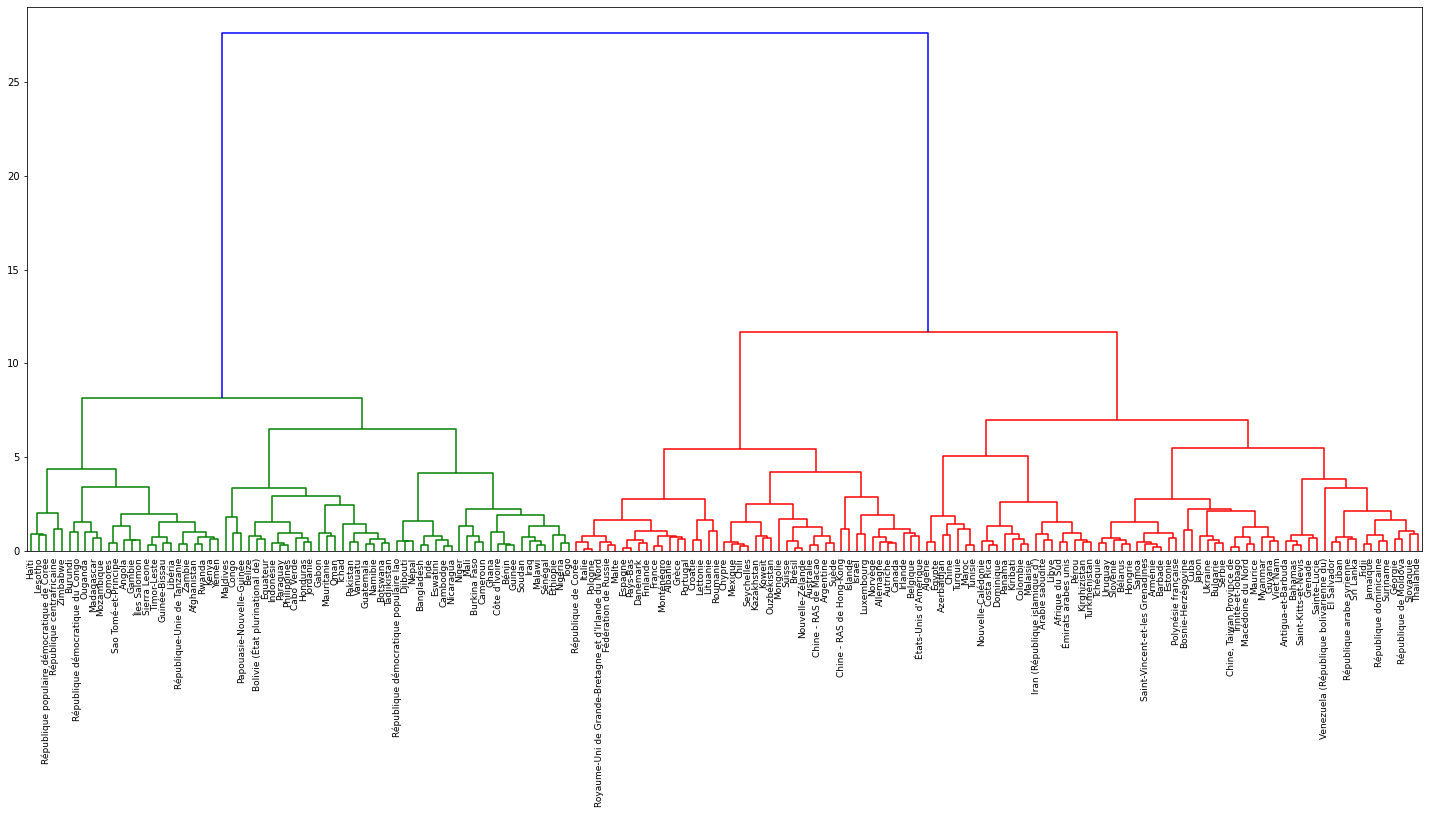

In [20]:
# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Clustering hiérarchique
Z = linkage(X_scaled, 'ward')

# Affichage du dendrogramme
fig, axes = plt.subplots(1,1)
fig.set_size_inches(25,10)
dn = hierarchy.dendrogram(Z,labels=names,orientation='top',leaf_font_size=9)
plt.show()

# IV) Selection des 5 groupes

In [21]:
groupes = fcluster(Z, 5, criterion="maxclust")
pays=pd.DataFrame({'groupe': groupes, 'Zone': names})
data2019=pd.merge(data2019,pays, how='left', on='Zone')

In [22]:

data2019[['dispo_prot','groupe']].pivot_table (index='dispo_prot', columns='groupe', aggfunc=len , fill_value=0)

groupe,1,2,3,4,5
dispo_prot,,,,,
9446.20,1,0,0,0,0
13932.05,1,0,0,0,0
15355.55,1,0,0,0,0
15552.65,1,0,0,0,0
15589.15,1,0,0,0,0
...,...,...,...,...,...
42872.90,0,0,1,0,0
42953.20,0,0,1,0,0
45975.40,0,0,1,0,0


# V) Coordonnées des centroïde de chaque groupe.

In [23]:
data2019.groupby('groupe').agg('mean')

,dispo_prot,dispo_cal,acc_pop,prt_prot_anim
groupe,,,,
1,18530.904000,7.905316e+05,4.559173,0.231976
2,25102.753333,9.607206e+05,4.183682,0.310465
3,39078.197778,1.237837e+06,1.097724,0.589490
4,32114.856818,1.135216e+06,2.736377,0.422215
5,30018.295238,1.060377e+06,0.454917,0.499677


In [24]:
data2019[data2019['groupe']==1]['prt_prot_anim'].quantile(0.89)

0.3082377218253868

# VI) Caractérisation des groupes

le groupe 1 est le groupe où le ratio moyen de protéine animal est plus faible. Ce ratio est de l'orde de 20% pour ce groupe. On note aussi que dans ce groupe 89% des pays ont un ratio de protéine animale inférieure à 29%. Aussi la disponibilité alimentaire par habitant et la disponiblité de calorie par habitant dans ce groupe sont inférieures. C'est le groupe où la croissance moyenne de la population entre 2017 et 2019 est plus forte.

Concernant les autres groupes on peut voir que le ratio moyen de protéine animale dépasse les 30%, notamment le groupe 3 qui a un ratio avoisinant les 60%. En retrant dans les détails on voit que 97% des pays de ce groupe ont un ration de protéine animale supérieur à 50%. On peut dire que ce groupe est composé de pays dont l'essentiel de leur protéine viennent des produits animaux. D'ailleurs on peut noter que ce groupe detient la disponibilité en proteine par habitant la plus grande et la disponilbilité en calorie par habitant la plus grande. On voit aussi que la croissance de la population de ce groupe est faible par rapport aux groupes 1,2 et 4.

Le groupe 2 a des caractérisqtiques assez proche du groupe 1. A la diiférence qu groupe 1, sauf 50% (contre 89% pour le groupe 1) des pays ont un ratio de protéine animale inférieure à 30%.

Les groupes 4 et 5 on aussi des caractéristiques assez similaire. La seule différence notable entre ces deux groupes se situe au niveau de la croissance moyenne de la population. Celle du groupe 4 est quatre fois plus élevée que celle du groupe 5.

En somme les pays à cibler sont les pays qui ont des caractéristiques similaires à celles du groupe 1.

In [25]:
data2019[data2019['Zone']=='Sénégal']

,Zone,dispo_prot,dispo_cal,acc_pop,prt_prot_anim,groupe
154,Sénégal,23458.55,949365.0,5.381689,0.227633,2


In [26]:
data2019[data2019['groupe']==1].quantile(0.90)

dispo_prot        22286.900000
dispo_cal        877752.000000
acc_pop               6.168251
prt_prot_anim         0.314045
groupe                1.000000
Name: 0.9, dtype: float64

In [27]:
groupes = fcluster(Z, 2, criterion="maxclust")
pays=pd.DataFrame({'groupe': groupes, 'Zone': names})
data2019=pd.merge(data2019,pays, how='left', on='Zone')

In [28]:
data2019

,Zone,dispo_prot,dispo_cal,acc_pop,prt_prot_anim,groupe_x,groupe_y
0,Afghanistan,20910.85,828915.0,4.589664,0.180485,1,1
1,Afrique du Sud,29101.45,1055215.0,2.643533,0.440487,4,2
2,Albanie,42332.70,1216910.0,-0.104131,0.538541,3,2
3,Algérie,33149.30,1273850.0,3.865004,0.265250,4,2
4,Allemagne,38036.65,1298670.0,1.028533,0.601862,3,2
...,...,...,...,...,...,...,...
174,Émirats arabes unis,29269.35,1126755.0,2.899843,0.445317,4,2
175,Équateur,23374.60,935130.0,3.390123,0.510306,2,1
176,États-Unis d'Amérique,41945.80,1409265.0,1.209487,0.660721,3,2
177,Éthiopie,25754.40,888410.0,5.066962,0.090845,2,1


In [29]:
data2019.groupby('groupe_y').agg('mean')

,dispo_prot,dispo_cal,acc_pop,prt_prot_anim,groupe_x
groupe_y,,,,,
1,22755.664286,8.999388e+05,4.317786,0.282433,1.642857
2,34181.781193,1.148745e+06,1.180774,0.521121,3.972477


ACP

# VII) Projection sur le plan factoriel



## Projection plan factoriel

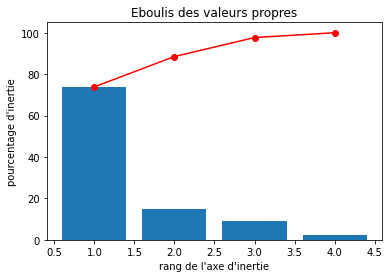

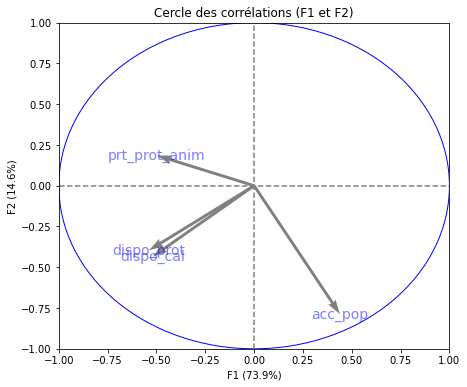

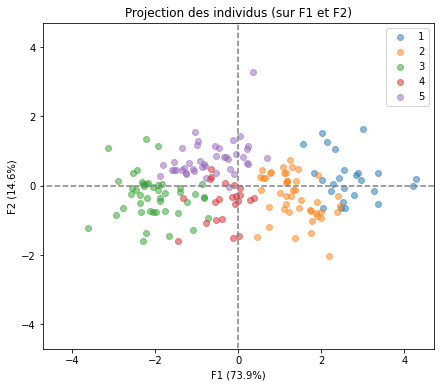

In [30]:
# choix du nombre de composantes à calculer
n_comp = 4

# Theme du ou des parcours auxquels appartient le cours (data, developpement, marketing, etc.)
themes=list(data2019['groupe_x'])

# préparation des données pour l'ACP
X = data2019[['dispo_prot',	'dispo_cal',	'acc_pop',	'prt_prot_anim']].values
features = data2019[['dispo_prot',	'dispo_cal',	'acc_pop',	'prt_prot_anim']].columns
features


# Centrage et Réduction
std_scale = preprocessing.StandardScaler().fit(X)
X_scaled = std_scale.transform(X)

# Calcul des composantes principales
pca = decomposition.PCA(n_components=n_comp)
pca.fit(X_scaled)


# Eboulis des valeurs propres
display_scree_plot(pca)

# Cercle des corrélations
pcs = pca.components_

display_circles(pcs, n_comp, pca, [(0,1)],  labels = np.array(features))

# Projection des individus

X_projected = pca.transform(X_scaled)
display_factorial_planes(X_projected, n_comp, pca, [(0,1)], illustrative_var = themes, alpha = 0.5)

plt.show()

# VIII) Test d'adéquation

In [31]:
from scipy.stats import shapiro
print('disponiblité protéine',shapiro(data2019['dispo_prot']))
print('disponibilité calorie',shapiro(data2019['dispo_cal']))
print('accroissement population',shapiro(data2019['acc_pop']))
print('proportion protéine animale',shapiro(data2019['prt_prot_anim']))

disponiblité protéine (0.9925389885902405, 0.49012047052383423)
disponibilité calorie (0.9874101281166077, 0.11088940501213074)
accroissement population (0.990425705909729, 0.2758018672466278)
proportion protéine animale (0.9582564234733582, 3.6821060348302126e-05)


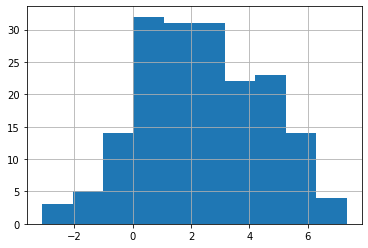

In [32]:
data2019['acc_pop'].hist()

# Test de comparaison

In [33]:
groupe_1=data2019[data2019['groupe_x']==1]
groupe_2=data2019[data2019['groupe_x']==2]
groupe_3=data2019[data2019['groupe_x']==3]
groupe_4=data2019[data2019['groupe_x']==4]
groupe_5=data2019[data2019['groupe_x']==5]

- Test d'égalité de la variance

In [34]:
from scipy.stats import bartlett
stat, p = bartlett(groupe_1['dispo_prot'], groupe_3['dispo_prot'])
p

0.4050839200012937

In [35]:
import scipy.stats as stats
stats.ttest_ind(groupe_1['dispo_prot'], groupe_5['dispo_prot'],equal_var=True)  

Ttest_indResult(statistic=-12.341218948563547, pvalue=1.079292744933222e-18)

p-value <0.05 on rejet l'hypothèse null (églaité des moyennes) avec un  seuil de confiance de 5%

In [36]:
stats.ttest_ind(groupe_1['dispo_prot'], groupe_5['dispo_prot'],equal_var=True) 

Ttest_indResult(statistic=-12.341218948563547, pvalue=1.079292744933222e-18)

# K-MEANS

In [37]:
from pandas import DataFrame
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=2).fit(data2019[['dispo_prot',	'dispo_cal',	'acc_pop',	'prt_prot_anim']])
centroids = kmeans.cluster_centers_
print(centroids)


[[  35668.19 1194009.47       1.31       0.53]
 [  24328.88  922533.62       3.4        0.34]]


In [38]:
data2019

,Zone,dispo_prot,dispo_cal,acc_pop,prt_prot_anim,groupe_x,groupe_y
0,Afghanistan,20910.85,828915.0,4.589664,0.180485,1,1
1,Afrique du Sud,29101.45,1055215.0,2.643533,0.440487,4,2
2,Albanie,42332.70,1216910.0,-0.104131,0.538541,3,2
3,Algérie,33149.30,1273850.0,3.865004,0.265250,4,2
4,Allemagne,38036.65,1298670.0,1.028533,0.601862,3,2
...,...,...,...,...,...,...,...
174,Émirats arabes unis,29269.35,1126755.0,2.899843,0.445317,4,2
175,Équateur,23374.60,935130.0,3.390123,0.510306,2,1
176,États-Unis d'Amérique,41945.80,1409265.0,1.209487,0.660721,3,2
177,Éthiopie,25754.40,888410.0,5.066962,0.090845,2,1
